In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Cargo el modelo y los datos a los que lo voy a aplicar 

In [6]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [7]:
import os
import joblib
# load model
#modelo = joblib.load("Analytics/5.Fraud/ModeloV1Todos.pkl") 
modelo = joblib.load("ModeloFinal_sin_rtc.pkl") 
variables = open('./ModeloFinal_sin_rtc.txt','r')
##ModeloV1T1

In [8]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

# Veo si puedo sacar los nombres directo del modelo q cargue


In [9]:
variables = open('./ModeloFinal2.txt','r')
var_input = variables.read()

In [10]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [11]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [12]:
testeo[var_input]

,01_branch_working_days,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,0.052826,131.0,2659.0,0,1,1,1,0,2.0,0,True,True,1.000000,False,False,False,True,False,0,0.635714,0.052826,0.216606,0.000000,0.172603,0.300000,0.583333
1,0.119738,109.0,1115.0,0,1,1,1,0,17.0,0,False,True,0.731183,False,False,False,True,False,0,0.183929,0.119738,0.021661,0.000000,0.016438,0.028571,0.666667
2,0.337246,933.0,877.0,0,1,1,1,0,5.0,0,False,True,0.390625,False,False,False,True,False,0,0.123214,0.337246,0.009025,0.000000,0.030137,0.052381,0.541667
3,0.287942,5.0,4494.0,0,2,2,2,0,12.0,0,False,True,2.432432,False,False,False,True,False,0,0.733929,0.287942,0.162455,0.000000,0.021918,0.038095,0.375000
4,0.234781,56.0,751.0,0,1,1,1,0,2.0,0,True,True,1.000000,False,False,False,True,False,0,0.837500,0.234781,0.722022,0.000000,0.161644,0.280952,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16724863,0.039074,3.0,942.0,0,5,2,5,0,1.0,0,True,False,1.000000,False,False,False,True,False,0,NaN,0.039074,0.036101,0.000000,NaN,NaN,0.541667
16724864,0.239980,60.0,2028.0,0,1,1,1,0,8.0,0,False,True,1.015873,False,False,False,True,False,0,0.987500,0.239980,0.144404,0.000000,0.019178,0.033333,0.500000
16724865,0.500252,0.0,10118.0,0,9,3,8,0,8.0,0,False,True,1.484117,False,False,False,True,False,0,0.212500,0.500252,0.105415,0.000000,0.019178,0.033333,0.750000
16724866,0.132316,126.0,3154.0,0,1,1,1,0,3.0,0,True,True,1.014085,False,False,False,True,False,0,0.617857,0.132316,0.043321,0.000000,0.035616,0.061905,0.541667


In [13]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')


In [14]:
#saco el punto de corte del primer centil para aplicarlo al test
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()

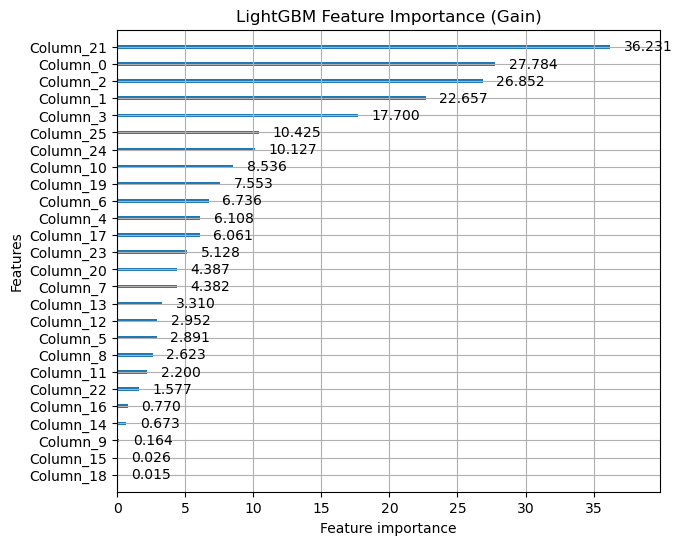

In [15]:
import lightgbm as lgb
lgb.plot_importance(modelo, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

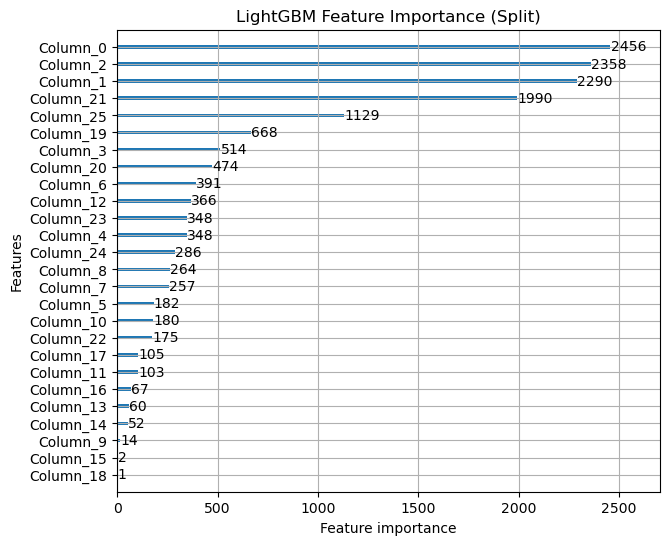

In [16]:
# Plot feature importance using Split
lgb.plot_importance(modelo, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [17]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
#np.savetxt('./ModeloFinalImp2.txt', modelo.booster_.feature_importance(importance_type='split'),fmt='%f')
#np.savetxt('./ModeloFinalImpG2.txt', modelo.booster_.feature_importance(importance_type='gain'),fmt='%f')

In [18]:
#Pongo el archivo q quiero testear
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']]

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target], tes[dias_target]], ignore_index=True)) 
testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [19]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [20]:
testeo['target'].value_counts(dropna=False)

target
False    6837374
True          26
Name: count, dtype: int64

In [21]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [22]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [23]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,6837374,0
1,26,0


In [24]:
corte

6.629883834307124e-07

In [25]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,6835743,1631
1,12,14


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

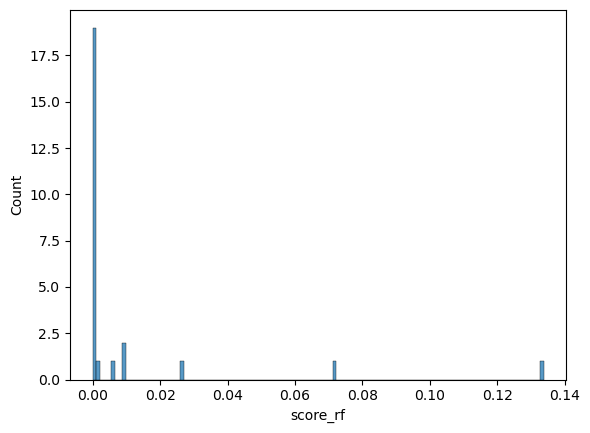

In [26]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [27]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA .04%:
0.7692307692307693


In [28]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,6819,18
2,6836,2
3,6838,0
4,6837,0
5,6837,0
...,...,...
996,6837,0
997,6837,0
998,6838,0


In [29]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.032479e-07  1.338115e-01
2             4.196728e-08  1.032448e-07
3             2.462346e-08  4.196691e-08
4             1.685838e-08  2.462268e-08
5             1.258713e-08  1.685445e-08
...                    ...           ...
996           7.025644e-14  8.133517e-14
997           5.840367e-14  7.025541e-14
998           4.563478e-14  5.840244e-14
999           3.051380e-14  4.563402e-14
1000          1.455868e-15  3.051278e-14

[1000 rows x 2 columns]

In [30]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]
pd.crosstab(tes_corte['date_receiver'].dt.month, Y_c_corte['target'])
#pd.crosstab(testeo['date_receiver'].dt.month, Y_c['target'])

target,False,True
date_receiver,,
1,491,14
2,539,0
3,601,0


In [31]:
tes_corte.to_csv ('./Corte.csv')

In [32]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,963,828,738,785,1186,1313,1024
2,887,809,724,791,1147,1377,1103
3,915,858,749,735,1169,1339,1073
4,903,762,739,753,1221,1385,1074
5,929,829,730,758,1153,1389,1049
6,894,833,713,720,1168,1359,1151
7,858,826,657,722,1249,1422,1103
8,951,823,702,727,1142,1365,1128
9,959,801,686,734,1157,1400,1100


In [33]:
#DECILES.to_csv ('./deciles.csv')

# Buckets para codificar Score

In [34]:
 Y_c['FRAUD_DECILE'].value_counts()

FRAUD_DECILE
918    6840
376    6839
707    6839
46     6839
434    6839
       ... 
154    6836
406    6836
89     6836
433    6836
917    6835
Name: count, Length: 1000, dtype: Int64

In [35]:
#Guardo los puntos de corte para recodificar el score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
Buckets = Buckets.reset_index()
Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
Buckets[['FRAUD_DECILE','min','max','final_score']].to_csv ('./Buckets.csv')

Y_c['score_rf2'] = 0
Y_c['score_rf2'] = Y_c['score_rf2'].astype(str) 
for i in range(Y_c.shape[0]):
    a = Buckets.loc[(Y_c.loc[i,'score_rf'] <= Buckets['max']) & (Y_c.loc[i,'score_rf'] >= Buckets['min']), 'final_score'] 
    Y_c.loc[i,'score_rf2'] = a.item()

In [36]:
#Y_c.loc[1,['score_rf2','FRAUD_DECILE']] 

In [37]:
Y_c.iloc[1]

day_name_receiver_0                    False
day_name_receiver_1                    False
day_name_receiver_2                     True
day_name_receiver_3                    False
day_name_receiver_4                    False
day_name_receiver_5                    False
day_name_receiver_6                    False
target                                 False
preds_rf                               False
score_rf              0.00000000033983390106
pred_corte                             False
FRAUD_DECILE                              69
Name: 1, dtype: object

In [38]:
Buckets[Buckets['FRAUD_DECILE']==644]

,FRAUD_DECILE,level_1,min,max,final_score
643,644,score_rf,0.00000000000496731901,0.00000000000499295754,0.35599999999999998312


## Curva ROC y FP

In [39]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [40]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [41]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [42]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
recall = recall_score(Y_c[['target']], Y_c['preds_rf'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
8.846140908281397
ROC FRAUD TESTEO:
0.5


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.8321441828397862


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision FRAUD TESTEO:
0.0
Recall FRAUD TESTEO:
0.0


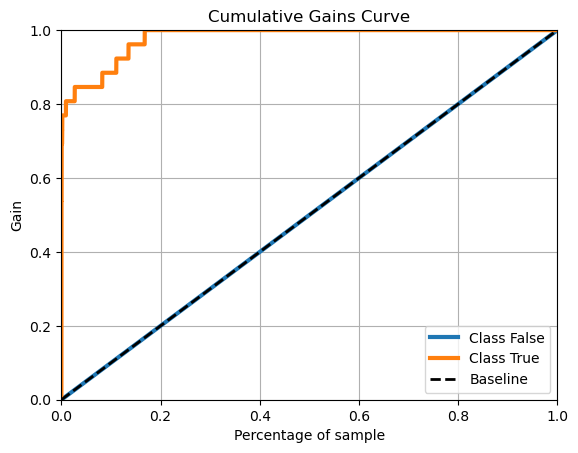

In [43]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


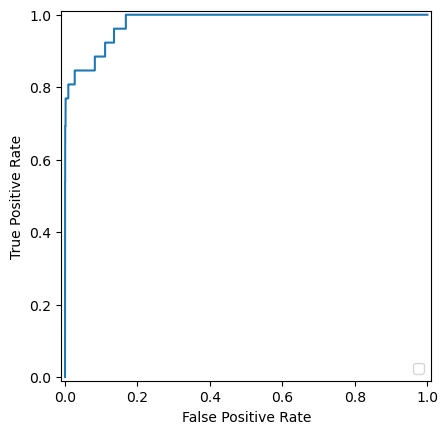

In [44]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

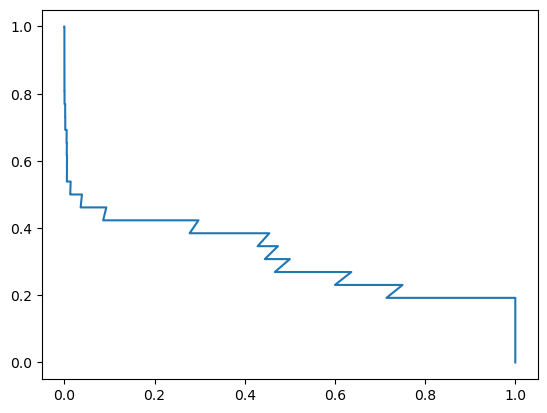

In [45]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(precision, recall)

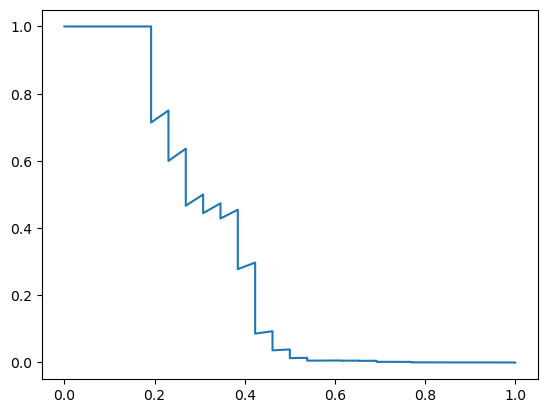

In [46]:
plt.plot(recall, precision)

## One given week

In [47]:
tes[tes['target']==True].head()

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
175528,A25718,47,2024-01-24 18:24:18.070,NY1546,NN,11306118,"1,500.00000000000000000000",1.00000000000000000000,MEX,MEX25,NY,65,NaN,NaN,USA,Real,NaN,8.00000000000000000000,0,40,CA,2,0,3,2,0,2,1,"1,500.00000000000000000000",0,1,18,True,False,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.02699983229917826688,0.54151624548736465581,NaN,NaN,NaN,NaN,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
221216,A25718,46,2024-01-24 18:16:31.533,NY1546,NN,10303412,"1,500.00000000000000000000",1.00000000000000000000,MEX,MEX33,NY,65,210.00000000000000000000,34.00000000000000000000,USA,Real,"49,208.00000000000000000000",9.00000000000000000000,0,39,CA,1,1,2,2,0,1,2,"1,700.00000000000000000000",1,1,18,True,False,0.88235294117647056211,True,True,True,True,False,True,34.00000000000000000000,0,34.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.37500000000000000000,0.02699983229917826688,0.54151624548736465581,0.00000000000000000000,0.00000000000000000000,0.09315068493150685525,0.16190476190476191243,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
308515,A22792,11766,2024-01-19 17:47:25.867,NV0185,NN,11283276,980.00000000000000000000,1.00000000000000000000,MEX,MEX27,NV,583,NaN,NaN,USA,Real,NaN,30.00000000000000000000,0,2475,NV,3,0,1,1,0,3,1,980.00000000000000000000,0,1,17,True,True,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.11386885795740399330,0.35379061371841152850,NaN,NaN,NaN,NaN,0.70833333333333337034,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
463631,A21721,16336,2024-01-14 15:09:23.963,FL2102,NN,10824482,"2,500.00000000000000000000",1.00000000000000000000,MEX,MEX9,FL,829,93.00000000000000000000,1.00000000000000000000,USA,Real,"1,217.00000000000000000000",38.00000000000000000000,0,2316,FL,0,0,2,1,0,0,5,"1,600.00000000000000000000",0,1,15,True,True,1.56250000000000000000,False,False,False,False,False,True,1.00000000000000000000,0,1.00000000000000000000,0,"1,217.00000000000000000000","1,217.00000000000000000000",0.00000000000000000000,0.16607142857142856429,0.15512326010397450848,0

In [48]:
week_testigo = tes['date_receiver'].between('2024-01-01','2024-01-30')
X_week_testigo = tes[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(1972832, (1972832, 77), (1972832, 12))

In [49]:
pd.crosstab(X_week_testigo['date_receiver'].dt.day, Y_c_week_testigo['target'])

target,False,True
date_receiver,,
1,14877,0
2,64369,0
3,53021,0
4,53556,0
5,82215,1
6,89445,0
7,75931,6
8,64412,0
9,49193,0


In [50]:
#Veo cuantos falsos positivos tengo con el punto de corte
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

target,False,True
date_receiver,,
1,8,0
2,15,0
3,9,0
4,6,0
5,8,0
6,13,0
7,12,5
8,24,0
9,7,0


In [51]:
Tabla_Week = pd.DataFrame(pd.concat([X_week_testigo['date_receiver'].dt.day,X_week_testigo['fraud_classification'], 
                                     Y_c_week_testigo['FRAUD_DECILE'], Y_c_week_testigo['target']],axis=1))

In [52]:
Tabla_Week[Tabla_Week['target']==True]
pd.crosstab(Tabla_Week.date_receiver, Tabla_Week.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
date_receiver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,23,16,16,12,11,12,6,11,15,15,19,11,7,14,16,12,9,9,14,16,14,13,18,13,11,20,11,15,10,14,19,19,18,16,17,14,13,22,16,14,9,14,18,12,8,15,15,17,16,8,11,15,24,17,6,18,14,21,13,15,9,15,19,22,15,13,21,11,18,10,10,13,12,19,11,13,10,19,5,12,18,12,6,14,13,18,13,18,13,11,10,14,23,14,8,17,13,15,11,15,12,11,13,14,19,13,18,12,19,18,15,16,17,19,13,15,12,18,15,10,13,13,16,14,27,18,18,13,14,8,22,13,14,13,23,10,12,11,16,9,16,17,12,21,12,15,20,15,15,14,12,16,20,14,17,20,13,10,19,17,14,17,19,12,18,9,15,12,14,6,7,18,16,10,7,14,25,22,17,20,25,10,11,21,20,11,16,10,9,9,10,9,12,16,19,13,14,19,16,10,16,17,10,11,11,11,8,16,13,8,16,16,19,16,16,16,16,11,19,15,24,17,8,13,19,15,10,14,17,8,8,13,11,12,22,13,20,11,14,21,14,12,7,8,16,18,18,15,16,14,...,15,11,17,9,9,14,19,19,13,14,22,10,17,10,12,6,19,9,24,19,12,20,14,10,14,19,8,13,16,12,13,9,10,19,17,10,14,15,14,17,9,17,17,14,13,13,15,13,12,23,13,12,21,13,19,10,11,15,17,12,13,13,20,9,9,12,7,19,15,17,10,12,14,15,16,15,15,10,20,14,23,23,15,16,25,16,10,12,18,11,15,19,13,14,21,14,15,12,17,13,15,20,11,21,10,13,9,10,18,15,13,12,23,20,11,13,16,11,11,15,15,11,10,19,13,12,17,14,12,12,8,15,10,19,17,6,16,6,12,19,11,10,24,22,12,12,11,22,17,20,19,12,10,13,17,15,16,14,20,16,15,14,13,10,12,20,10,17,22,11,14,22,15,11,18,12,17,9,12,11,20,13,16,17,20,9,22,14,16,21,17,19,16,18,15,15,18,14,20,19,17,14,15,19,19,19,12,25,20,27,18,16,20,18,29,15,10,17,11,16,19,18,17,21,21,18,15,19,20,14,28,24,15,25,18,19,18,30,27,16,16,26,15,21,20,22,18,27,21,18
2,57,62,64,54,51,55,49,74,65,61,50,56,70,53,57,49,57,52,67,62,69,60,60,67,60,47,60,67,61,55,62,55,60,57,43,67,61,

In [53]:

pd.crosstab(Tabla_Week.date_receiver[Tabla_Week['target']==True], Tabla_Week.FRAUD_DECILE[Tabla_Week['target']==True])

FRAUD_DECILE,1,2,10,27,83
date_receiver,,,,,
5,0,0,0,0,1
7,6,0,0,0,0
14,2,0,0,1,0
19,4,0,1,0,0
21,3,1,0,0,0
24,3,0,0,0,0


In [54]:
Tabla_Week.loc[Tabla_Week['target']==True,['date_receiver','fraud_classification','FRAUD_DECILE']]

,date_receiver,fraud_classification,FRAUD_DECILE
175528,24,Real,1
221216,24,Real,1
308515,19,Real,1
463631,14,Real,27
491365,5,Real,83
517827,24,Real,1
573207,21,Real,1
637476,7,Real,1
648478,7,Real,1
777154,7,Real,1


# Analisis extra por cantidad FP

In [55]:
var_input

['01_branch_working_days',
 'branch_minutes_since_last_transaction',
 'branch_trans_3m',
 'branch_has_fraud',
 'branch_trans_40min',
 'branch_trans_10min',
 'cash_pick_up_40min',
 'location_nro_fraud',
 'sender_trans_3m',
 'sender_nro_fraud',
 '01_isMexico',
 '01_sender_branch_state',
 '01_var_range_hist',
 '01_branch_fraud',
 '01_location_fraud',
 '01_sender_fraud',
 '01_isCashPick',
 '01_isBankDep',
 'sender_days_to_last_transaction_more7m',
 '01_sender_sending_days',
 '01_branch_working_days',
 '01_net_amount_receiver',
 '01_sender_minutes_since_last_transaction_2days',
 '01_sender_days_to_last_transaction_365',
 '01_sender_days_to_last_transaction_7m',
 '01_hour_receiver']

In [56]:
testeo.loc[(testeo['id_receiver'] ==30890) & (testeo['id_branch'] =='A14536')] 
#testeo['id_branch'] =='A14536'

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
4417693,A14536,30890,2024-03-20 12:42:15.783,MA0108,NN,5717054,"1,050.50000000000000000000",1.00000000000000000000,BRA,BRA2,MA,2751,888.00000000000000000000,35.00000000000000000000,USA,None,"50,478.00000000000000000000",24.00000000000000000000,0,1116,MA,0,0,2,1,0,0,4,"2,492.06999999999970896170",0,3,12,False,True,0.42153711573109908795,False,False,False,False,False,True,35.00000000000000000000,0,35.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.47744423947677344655,0.37924187725631769430,0.00000000000000000000,0.00000000000000000000,0.09589041095890410427,0.16666666666666665741,0.50000000000000000000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date_receiver', ylabel='Count'>

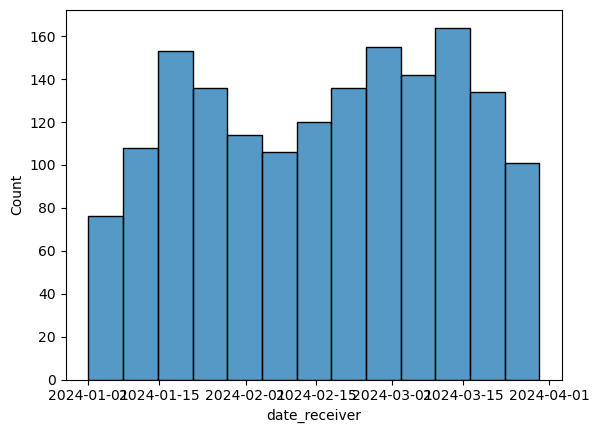

In [57]:
sns.histplot(data = tes_corte['date_receiver'].dt.floor('d'))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date_receiver', ylabel='Count'>

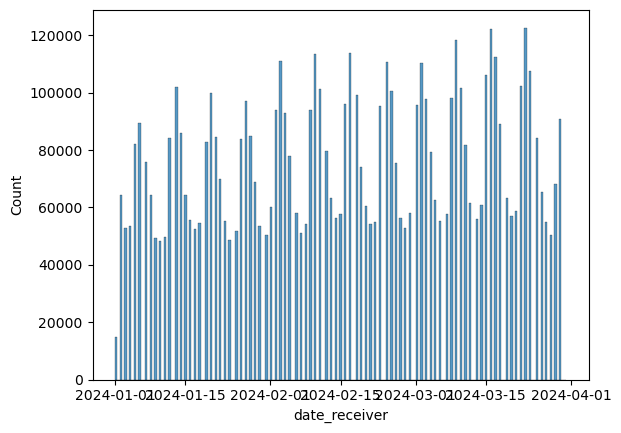

In [58]:
sns.histplot(data = testeo['date_receiver'].dt.floor('d'))

In [59]:

Alertas_2024 = pd.crosstab(tes_corte['date_receiver'].dt.floor('d'), Y_c_corte['target'])
Alertas_2024.to_csv ('./alertas2024.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ec2-user/anaconda3/envs/python

<Axes: xlabel='01_var_range_hist', ylabel='Count'>

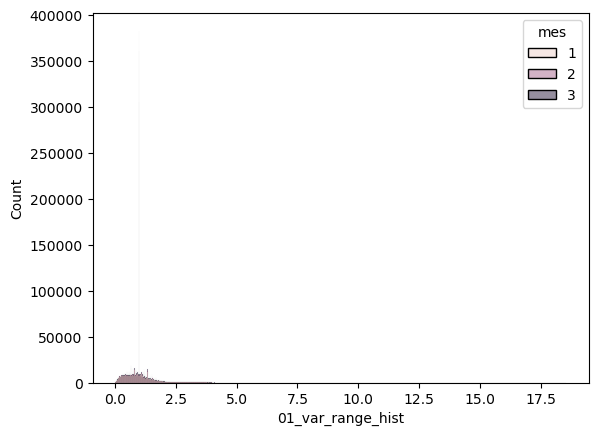

In [60]:
sns.histplot(data = testeo, x='01_var_range_hist', hue = 'mes')


In [61]:
testeo[testeo['mes']==1].describe()

,id_receiver,date_receiver,id_sender_global,net_amount_receiver,receiver_transaction_count,branch_working_days,sender_sending_days,sender_days_to_last_transaction,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_var_range_hist,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
count,"2,076,906.00000000000000000000",2076906,"2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,874.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000","2,076,906.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","1,966,709.00000000000000000000","2,076,906.00000000000000000000"
mean,"67,332.80096403014613315463",2024-01-17 03:25:09.707793152,"8,267,104.98367908783257007599",457.34215281105622352698,1.01808555611086881676,"1,599.41525134021480880619",555.94958481402181860176,30.71975416800350089375,"44,240.69602518725150730461",111.74940993050131510245,0.00000000000000000000,"3,671.45134348882402264280",0.09055296676883788087,0.01347774044660663556,4.14846555405011141460,1.91383047668021566423,2.69588031427517682559,0.09084282100393566151,8.39999065918245690909,461.67398417969303636710,0.00008377846662294778,1.00000000000000000000,15.26093381212245603251,0.98341650062590801884,23.58870987014347164745,0.01139531591704198536,19.65989884624517358702,0.02492601976208841386,94.08835013212427611506,24.80822175522662575986,0.00017906491198879960,0.69327086246254909785,0.28359056443884794740,0.16233055222583747668,0.03266956601809870020,0.01722793177446291582,0.06462660238395474821,0.09361856593450085251,0.63587224217176896435
min,1.00000000000000000000,2024-01-01 03:00:23.573000,9.00000000000000000000,0.00000000000000000000,1.00000000000000000000,-19.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,1.00000000000000000000,3.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.01291296327352003948

In [62]:
testeo[testeo['mes']==3].describe()

,id_receiver,date_receiver,id_sender_global,net_amount_receiver,receiver_transaction_count,branch_working_days,sender_sending_days,sender_days_to_last_transaction,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_var_range_hist,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
count,"2,493,885.00000000000000000000",2493885,"2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,488,376.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000","2,493,885.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,377,497.00000000000000000000","2,493,885.00000000000000000000"
mean,"67,147.78369291286799125373",2024-03-15 19:30:47.806508544,"8,397,131.44546440616250038147",440.77123431790124641338,1.01637685779416453435,"1,585.12772240901244913402",578.95790993637422161555,33.05045768722315813193,"47,598.26427709477866301313",96.54369596877641868105,0.00000000000000000000,"3,485.99444360906772999442",0.08959795660184811938,0.01594139264641312656,4.45229310894447838365,2.00665868714876571843,2.91195544301361142203,0.08983573821567554518,7.95960038253568225031,438.92972999902156061580,0.00008500792939530091,3.00000000000000000000,15.48751526233166408986,1.00616651224199982195,24.07418810623104832302,0.01389719253293556119,19.86344083714932295948,0.02840146999560926033,99.13195137575357307469,26.57468169255313483745,0.00016999203814907496,0.70379000478234055027,0.28106642592540698189,0.15680292913954888001,0.03442081644991445977,0.01845464006427303266,0.06595667974309876724,0.09458781351023486106,0.64531313593048589272
min,1.00000000000000000000,2024-03-01 03:00:17.187000,9.00000000000000000000,0.73999999999999999112,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.91266666666666662611,0.00000000000000000000,3.00000000000000000000,3.00000000000000000000,0.00066489067717885424,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.01609927888646654412,0.

for var in var_input:
    sns.histplot(data = tes_corte, x=var, hue = 'mes')
    plt.show()

In [64]:
week_fraude = tes['date_receiver'].between('2024-02-02','2024-02-11')
X_fraude = tes[week_fraude]
Y_c_fraude = Y_c[week_fraude]
Y_c_fraude

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,FRAUD_DECILE
2076909,False,False,True,False,False,False,False,False,False,0.00000000001959330746,False,377
2076910,False,False,False,False,False,True,False,False,False,0.00000000004896190890,False,233
2076915,False,False,False,False,True,False,False,False,False,0.00000000000812535859,False,547
2076917,False,False,False,False,False,True,False,False,False,0.00000000000923359259,False,522
2076920,False,False,False,False,True,False,False,False,False,0.00000000000342565099,False,714
...,...,...,...,...,...,...,...,...,...,...,...,...
4343505,False,True,False,False,False,False,False,False,False,0.00000000000566351348,False,619
4343509,False,False,True,False,False,False,False,False,False,0.00000000000057578429,False,937
4343511,False,False,True,False,False,False,False,False,False,0.00000000003973135248,False,262
4343512,False,False,False,False,False,False,True,False,False,0.00000000017059865615,False,108


In [65]:
week_fraude = tes['date_receiver'].between('2024-03-21','2024-03-22')
X_fraude = tes[week_fraude]
Y_c_fraude = Y_c[week_fraude]
X_fraude[Y_c_fraude['pred_corte']==True].sort_values(by=['id_branch'])

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
6083064,A01614,39144,2024-03-21 14:53:48.657,NC0054,NN,3833562,690.00000000000000000000,1.00000000000000000000,MEX,MEX33,NC,6277,378.00000000000000000000,2.00000000000000000000,USA,None,"2,835.00000000000000000000","1,142.00000000000000000000",0,2140,NC,0,0,1,1,0,0,15,458.60000000000002273737,0,3,14,True,True,1.50457915394679453414,False,False,False,False,False,True,2.00000000000000000000,0,2.00000000000000000000,0,"2,835.00000000000000000000",0.00000000000000000000,0.00000000000000000000,0.67500000000000004441,1.00000000000000000000,0.24909747292418771281,0.98437500000000000000,0.00000000000000000000,0.00547945205479452059,0.00952380952380952467,0.58333333333333337034,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5179896,A22984,18818,2024-03-21 22:53:42.490,CO0546,NN,11579090,980.00000000000000000000,1.00000000000000000000,MEX,MEX22,CO,594,NaN,NaN,USA,None,NaN,39.00000000000000000000,0,4319,CO,0,0,2,1,1,0,1,980.00000000000000000000,0,3,22,True,True,1.00000000000000000000,False,False,False,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.11571356699647827870,0.35379061371841152850,NaN,NaN,NaN,NaN,0.91666666666666662966,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5769131,A23349,1486,2024-03-21 08:24:54.233,OH0193,NN,9288204,"2,200.00000000000000000000",1.00000000000000000000,MEX,MEX5,OH,525,495.00000000000000000000,16.00000000000000000000,USA,None,"23,026.00000000000000000000",5.00000000000000000000,0,299,GA,0,0,2,2,0,0,6,"2,416.66666666666651508422",0,3,8,True,False,0.91034482758620693943,False,False,False,False,False,True,16.00000000000000000000,0,16.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.88392857142857139685,0.10414221029683044806,0.79422382671480140637,0.00000000000000000000,0.00000000000000000000,0.04383561643835616473,0.07619047619047619735,0.33333333333333331483,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4966382,A23864,5766,2024-03-21 15:41:07.237,CA4351,NN,4169007,"1,206.00000000000000000000",1.00000000000000000000,MEX,MEX11,CA,406,385.00000000000000000000,33.00000000000000000000,USA,None,"47,346.00000000000000000000",4.00000000000000000000,0,1362,CA,2,0,4,3,3,2,2,663.000000000000

In [66]:
#Y_c[tes['id_barnch'].str.contains('A24793')].sort_values(by=['id_receiver'])
testeo.loc[(testeo['id_receiver'] ==5619) & (testeo['id_branch'] =='A24793')] 

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
